In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autocast
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [6]:
pipe = StableDiffusionPipeline.from_pretrained(
    "/mnt/mydrive/datas/model/sd/stable-diffusion-v1-4",
    revision="fp16", torch_dtype=torch.float16
).to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

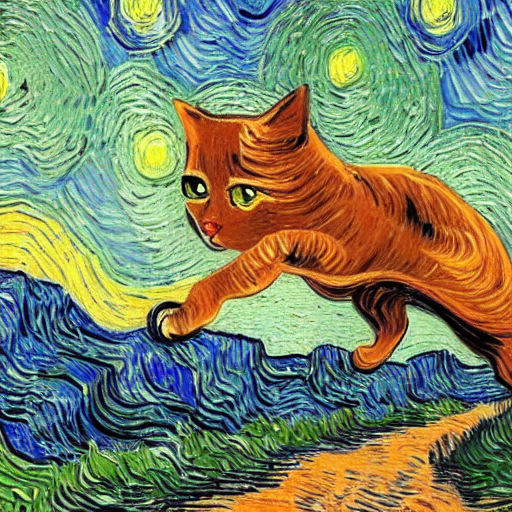

In [7]:
prompt = "a lovely cat running in the desert in Van Gogh style, trending art."
image = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"lovely_cat.png")
image

  0%|          | 0/50 [00:00<?, ?it/s]

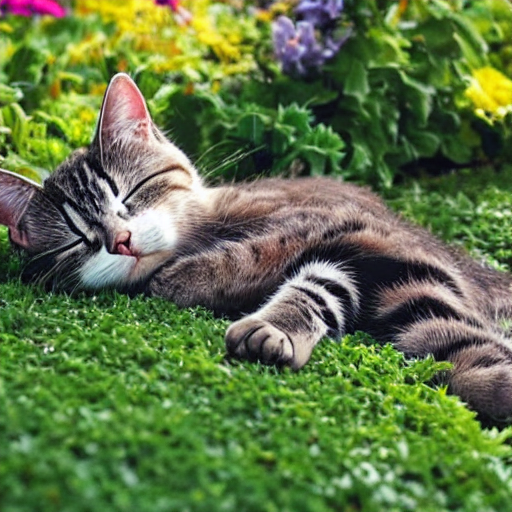

In [12]:
# fixing the random seed
generator = torch.Generator("cuda").manual_seed(1024)

prompt = "a sleeping cat having fun in garden"
image = pipe(prompt, generator=generator).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"lovely_cat_sun.png")
image

  0%|          | 0/15 [00:00<?, ?it/s]

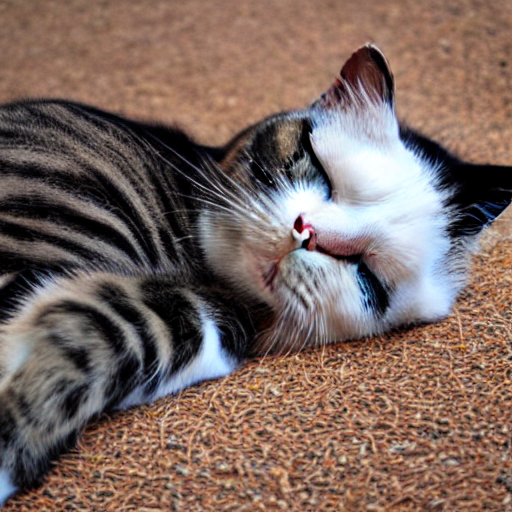

In [11]:
# changing the diffusion steps
prompt = "a sleeping cat enjoying the sunshine."
image = pipe(prompt, num_inference_steps=15).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"lovely_cat_sun.png")
image

  0%|          | 0/50 [00:00<?, ?it/s]

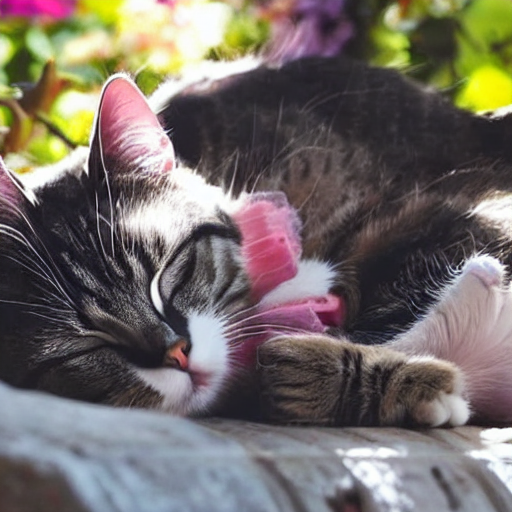

In [31]:
# adding negative prompt
generator = torch.Generator("cuda").manual_seed(1024)

prompt = "a sleeping cat having fun in garden."
image = pipe(prompt, generator=generator, negative_prompt="grass", guidance_scale=8.5).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"garden_without_grass.png")
image

# visualize the diffusion in action

In [13]:
import itertools
import math
import mediapy as media

In [14]:
!mkdir diffprocess

In [21]:
@torch.no_grad() # save the gpu memory
def plot_show_callback(i, t, latents):
    latents_reservoir.append(latents.detach().cpu())
    image = pipe.vae.decode(1 / 0.18215 * latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()[0]
    # plt_show_image(image)
    plt.imsave(f"diffprocess/sample_{i:02d}.png", image)
    image_reservoir.append(image)


@torch.no_grad() # save the gpu memory
def save_latents(i, t, latents):
    latents_reservoir.append(latents.detach().cpu())

image_reservoir = []
latents_reservoir = []

  0%|          | 0/50 [00:00<?, ?it/s]

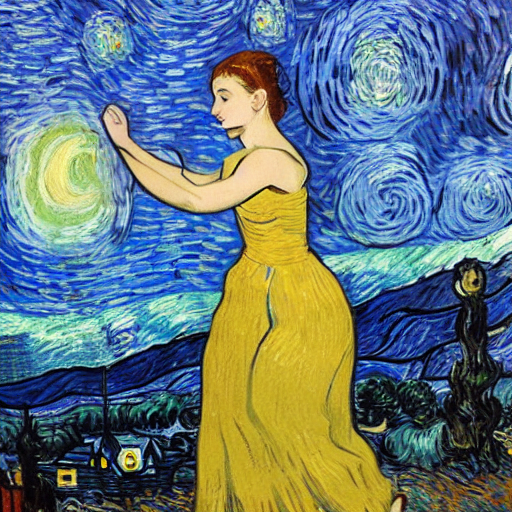

In [22]:
prompt = "a girl dancing in the moonlight in van gogh style, trending art."
with torch.no_grad():
  image = pipe(prompt, callback=plot_show_callback).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can do either save it such as:
image.save(f"gentle_girl.png")
image

In [23]:
media.show_video(image_reservoir, fps=5)

# visualizing latents

In [29]:
latents_reservoir[0].shape, image_reservoir[0].shape

(torch.Size([1, 4, 64, 64]), (512, 512, 3))

In [32]:
Chan2RGB = [0,1,2]
latents_np_seq = [latent[0, Chan2RGB].permute(1,2,0).numpy() for latent in latents_reservoir]


In [33]:
media.show_video(latents_np_seq, fps=5)

In [ ]:
# 1. diffusers api [optional]
# 2. jump into training with diffusers